In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd
import glob, os, gc
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.model_selection import KFold

# Add the path to the directory containing the module
import sys
sys.path.append('../../')
from util.ml import baseline, metrics, nestedMLR, fno

from properscoring import crps_ensemble  # For CRPS calculation
from sklearn.utils import resample  # For bootstrapping

In [16]:
# Find the folder name organized by seed number
seed_doc = sorted(glob.glob('../../datas/seed_revised_*/'))[0]
# Variances explained
varsexp_filename = str(80)
# Load the data
# Load the time series data
df = pd.read_csv(seed_doc +'X_train_ts_all.csv')
df_valid = pd.read_csv(seed_doc +'X_validation_ts_all.csv')
df_test = pd.read_csv(seed_doc +'X_test_ts_all.csv')

# Find the name for each column
column_names = ([obj.split('_step_')[0] for obj in df.columns])
# Unique names in the column name list
unique_names = list(set(column_names))
# Remove strings with large_scale
unique_names_filt = [var for var in unique_names if "large_scale" not in var]

# Now we read in the y data for every fold
y_train = []
y_val = []
for i in range(7):
    y_train.append(baseline.load_pickle(f'../../datas/proc/sfs/y/ytrain_split_{i}.pkl'))
    y_val.append(baseline.load_pickle(f'../../datas/proc/sfs/y/yval_split_{i}.pkl'))

# Load the test data
y_test = baseline.load_pickle('../../datas/proc/sfs/y/ytest.pkl')

In [12]:
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [13]:
def r2_score_f(y_true,y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    r2 = 1-np.sum((y_true-y_pred)**2)/np.sum((y_true-np.mean(y_true))**2)
    return r2

In [14]:
def train_SFFS(remaining_vars, pcs_train, pcs_val, pcs_test, y_train, y_val, y_test, target_cat, best_val_rmse, varsexp_filename, F_cutoff, strategy):
    
    # Track RMSEs
    rmse_log = []  # List to log RMSE values for each iteration
    selected_pcs = []  # List to store selected PCs
    
    while remaining_vars:  
        best_var = None
        best_pc_index = None
        best_mean_val_rmse = best_val_rmse
        best_mean_train_rmse = None
        best_mean_test_rmse = None
        best_mean_train_r2 = None
        best_mean_val_r2 = None
        best_mean_test_r2 = None
        
        # Test each variable
        for var in remaining_vars:
            nPC = pcs_train[0][var].shape[1]  # Number of PCs for this variable
            
            # Test each PC of the variable
            for pc_index in range(nPC):
                train_scores = []
                test_scores = []
                mean_score = []
                train_r2 = []
                test_r2 = []
                valid_r2 = []
                
                # Evaluate using all seeds
                for iseed in range(7):
                    # Prepare data for the current candidate PC
                    candidate_features = [pcs_train[iseed][sel_var][:, [pc_idx]] for sel_var, pc_idx in selected_pcs]
                    candidate_features.append(pcs_train[iseed][var][:, [pc_index]])
                    X_train_subset = np.hstack(candidate_features)
                    X_val_subset = np.hstack([pcs_val[iseed][sel_var][:, [pc_idx]] for sel_var, pc_idx in selected_pcs] +[pcs_val[iseed][var][:, [pc_index]]])
                    X_test_subset = np.hstack([pcs_test[iseed][sel_var][:, [pc_idx]] for sel_var, pc_idx in selected_pcs] +[pcs_test[iseed][var][:, [pc_index]]])
                
                    # Train a model and evaluate
                    model = linear_model.LinearRegression()
                    model.fit(X_train_subset, y_train[iseed][target_cat])
                    y_pred = model.predict(X_val_subset)
                    
                    # Training RMSE
                    y_train_pred = model.predict(X_train_subset)
                    train_rmse = mean_squared_error(y_train[iseed][target_cat], y_train_pred, squared=False)
                    train_r2z = -r2_score_f(y_train[iseed][target_cat], y_train_pred)
                    train_scores.append(train_rmse)
                    train_r2.append(train_r2z)
                    
                    # Calculate the validation RMSE
                    val_rmse = mean_squared_error(y_val[iseed][target_cat], y_pred, squared=False)
                    val_r2z = -r2_score_f(y_val[iseed][target_cat], y_pred)
                    mean_score.append(val_rmse)
                    valid_r2.append(val_r2z)

                    # Calculate the test RMSE
                    test_rmse = mean_squared_error(y_test[target_cat], model.predict(X_test_subset), squared=False)
                    test_r2z = -r2_score_f(y_test[target_cat], model.predict(X_test_subset))
                    test_scores.append(test_rmse)
                    test_r2.append(test_r2z)

                if strategy == "mean":
                    # Compute the mean training RMSE across seeds
                    mean_train_rmse = np.mean(train_scores)
                    # Compute the mean validation RMSE across seeds
                    mean_val_rmse = np.mean(mean_score)
                    # Compute the mean test RMSE across seeds
                    mean_test_rmse = np.mean(test_scores)
                    # Compute the mean training R2 across seeds
                    mean_train_r2 = np.mean(train_r2)
                    # Compute the mean validation R2 across seeds
                    mean_val_r2 = np.mean(valid_r2)
                    # Compute the mean test R2 across seeds
                    mean_test_r2 = np.mean(test_r2)
                elif strategy == "max":
                    mean_train_rmse = np.max(train_scores)
                    mean_val_rmse = np.max(mean_score)
                    mean_test_rmse = np.max(test_scores)
                    mean_train_r2 = np.max(train_r2)
                    mean_val_r2 = np.max(valid_r2)
                    mean_test_r2 = np.max(test_r2)

                # Update the best PC if this one performs better
                if mean_val_rmse < best_mean_val_rmse:
                    best_mean_val_rmse = mean_val_rmse
                    best_mean_train_rmse = mean_train_rmse
                    best_mean_test_rmse = mean_test_rmse
                    best_mean_train_r2 = mean_train_r2
                    best_mean_val_r2 = mean_val_r2
                    best_mean_test_r2 = mean_test_r2
                    best_var = var
                    best_pc_index = pc_index

        # Check if we found a PC that improves validation RMSE
        if best_var and best_mean_val_rmse < best_val_rmse:
            # Add the best-performing PC to the selected set
            selected_pcs.append((best_var, best_pc_index))
            remaining_vars.remove(best_var)
            best_val_rmse = best_mean_val_rmse
            
            # Log RMSEs for this iteration
            rmse_log.append({
                "selected_pc": f"{best_var}_PC{best_pc_index + 1}",
                "train_rmse": best_mean_train_rmse,
                "val_rmse": best_mean_val_rmse,
                "test_rmse": best_mean_test_rmse,
                "train_r2": best_mean_train_r2,
                "val_r2": best_mean_val_r2,
                "test_r2": best_mean_test_r2
                })
            print(f"Selected PC: {best_var}_PC{best_pc_index + 1}, Train RMSE: {best_mean_train_rmse}, Val RMSE: {best_mean_val_rmse}")
        else:
            print("No improvement. Stopping feature selection.")
            break
    
    # Train the final model using all selected PCs and all training data
    final_X_train = np.hstack(
        [pcs_train[0][sel_var][:, [pc_idx]] for sel_var, pc_idx in selected_pcs]
        )
    final_model = linear_model.LinearRegression()
    final_model.fit(final_X_train, y_train[0][target_cat])

    # Create subfolder
    os.makedirs(f'../../datas/proc/sfs/PCcomp_var{varsexp_filename}/results/smooth{F_cutoff}/', exist_ok=True)
    # Save the final model
    baseline.save_models(final_model,f'../../datas/proc/sfs/PCcomp_var{varsexp_filename}/results/smooth{F_cutoff}/best_linear_{target_cat}_model_{strategy}.pkl')
    baseline.save_models(selected_pcs,f'../../datas/proc/sfs/PCcomp_var{varsexp_filename}/results/smooth{F_cutoff}/best_linear_{target_cat}_feature_{strategy}.pkl')
    baseline.save_models(rmse_log,f'../../datas/proc/sfs/PCcomp_var{varsexp_filename}/results/smooth{F_cutoff}/best_linear_{target_cat}_RMSElog_{strategy}.pkl')
    return final_model, selected_pcs, rmse_log

In [6]:
os.makedirs(f'../../datas/proc/sfs/PCcomp_var{varsexp_filename}/results/', exist_ok=True)
strategy = 'max'
for F_cutoff in [3,5,7,9,11,13]:
    pcs_train = baseline.load_pickle(f'../../datas/proc/sfs/PCcomp_var{varsexp_filename}/pcs/pcsall_smooth{F_cutoff}_train.pkl')
    pcs_val = baseline.load_pickle(f'../../datas/proc/sfs/PCcomp_var{varsexp_filename}/pcs/pcsall_smooth{F_cutoff}_valid.pkl')
    pcs_test = baseline.load_pickle(f'../../datas/proc/sfs/PCcomp_var{varsexp_filename}/pcs/pcsall_smooth{F_cutoff}_test.pkl')  
    # List of variable names
    var_names = list(pcs_train[0].keys())
    
    # Empty list to store the chosen variables
    selected_vars = []
    # List to store all the variable choices
    remaining_vars = [var for var in var_names if "large_scale" not in var].copy()
    # Initial RMSE to beat is infinity
    best_val_rmse = float('inf')
    # Seed
    seed = 42
    
    # Initialize variables
    remaining_vars = [var for var in var_names if "large_scale" not in var].copy()  # All variables initially available for selection
    tofilt = ['_10_', '_20_', '_30_', '_50_', '_70_']
    remaining_vars = [var for var in remaining_vars if not any(substring in var for substring in tofilt)] # Filter out specific pressure levels
    best_val_rmse = float('inf')  # Start with a very high RMSE value
    target_cat = 'cdf'
    
    final_model, selected_pcs, rmse_log = train_SFFS(remaining_vars, pcs_train, pcs_val, pcs_test, y_train, y_val, y_test, target_cat, best_val_rmse, varsexp_filename, F_cutoff, strategy)

Selected PC: mean_surface_net_long_wave_radiation_flux_max_PC1, Train RMSE: 1.3486557611972714, Val RMSE: 1.6499981112092434
Selected PC: relative_humidity_925_mean_PC1, Train RMSE: 1.3010407727662323, Val RMSE: 1.5591226188503842
Selected PC: relative_humidity_100_std_PC1, Train RMSE: 1.2540327306713626, Val RMSE: 1.4806478252296065
Selected PC: relative_humidity_400_max_PC2, Train RMSE: 1.2242014606719134, Val RMSE: 1.4422210132556958
Selected PC: relative_humidity_1000_max_PC1, Train RMSE: 1.1865660737718786, Val RMSE: 1.420271789653723
Selected PC: 100m_magnitude_of_wind_min_PC2, Train RMSE: 1.1571888317577923, Val RMSE: 1.4011898264171543
Selected PC: surface_latent_heat_flux_std_PC3, Train RMSE: 1.1455155925946907, Val RMSE: 1.3853412888646865
Selected PC: geopotential_500_mean_PC1, Train RMSE: 1.1313863284786243, Val RMSE: 1.3753656077699659
Selected PC: relative_humidity_400_std_PC4, Train RMSE: 1.1084645243615894, Val RMSE: 1.3529480153809887
Selected PC: total_precipitation_m

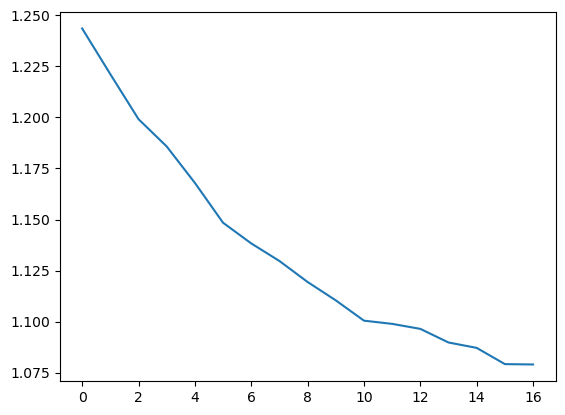

In [11]:
plt.plot([obj['val_rmse'] for obj in rmse_log])
plt.show()

Max

In [17]:
strategy = 'max'
for F_cutoff in [3,5,7,9,11,13]:
    pcs_train = baseline.load_pickle(f'../../datas/proc/sfs/PCcomp_var{varsexp_filename}/pcs/pcsall_smooth{F_cutoff}_train.pkl')
    pcs_val = baseline.load_pickle(f'../../datas/proc/sfs/PCcomp_var{varsexp_filename}/pcs/pcsall_smooth{F_cutoff}_valid.pkl')
    pcs_test = baseline.load_pickle(f'../../datas/proc/sfs/PCcomp_var{varsexp_filename}/pcs/pcsall_smooth{F_cutoff}_test.pkl')  
    # List of variable names
    var_names = list(pcs_train[0].keys())
    
    # Empty list to store the chosen variables
    selected_vars = []
    # List to store all the variable choices
    remaining_vars = [var for var in var_names if "large_scale" not in var].copy()
    # Initial RMSE to beat is infinity
    best_val_rmse = float('inf')
    # Seed
    seed = 42
    
    # Initialize variables
    remaining_vars = [var for var in var_names if "large_scale" not in var].copy()  # All variables initially available for selection
    tofilt = ['_10_', '_20_', '_30_', '_50_', '_70_']
    remaining_vars = [var for var in remaining_vars if not any(substring in var for substring in tofilt)] # Filter out specific pressure levels
    best_val_rmse = float('inf')  # Start with a very high RMSE value
    target_cat = 'max'
    
    final_model, selected_pcs, rmse_log = train_SFFS(remaining_vars, pcs_train, pcs_val, pcs_test, y_train, y_val, y_test, target_cat, best_val_rmse, varsexp_filename, F_cutoff, strategy)

Selected PC: geopotential_500_std_PC1, Train RMSE: 5.663869335130596, Val RMSE: 6.474824258123761
Selected PC: relative_humidity_975_max_PC1, Train RMSE: 5.2929761936753295, Val RMSE: 5.9023194733003645
Selected PC: mean_surface_sensible_heat_flux_std_PC1, Train RMSE: 5.137420758450049, Val RMSE: 5.637018932454446
Selected PC: mean_top_net_long_wave_radiation_flux_std_PC2, Train RMSE: 5.035853087925506, Val RMSE: 5.5540269605863495
Selected PC: relative_humidity_100_mean_PC1, Train RMSE: 4.959976748016667, Val RMSE: 5.525090388151079
Selected PC: relative_humidity_400_max_PC2, Train RMSE: 4.8359505291095495, Val RMSE: 5.433772714775851
No improvement. Stopping feature selection.
Selected PC: geopotential_500_std_PC1, Train RMSE: 5.663810878456705, Val RMSE: 6.474786109078112
Selected PC: relative_humidity_975_max_PC1, Train RMSE: 5.287448347679268, Val RMSE: 5.883347384999356
Selected PC: mean_surface_sensible_heat_flux_std_PC1, Train RMSE: 5.133629108876819, Val RMSE: 5.63531731280545